# Contextual Bandit (Answered by Chat GPT)

A contextual bandit is a type of reinforcement learning algorithm used to make decisions in situations where each decision (or action) results in some reward, and the goal is to maximize the total reward over time. It is an extension of the multi-armed bandit problem, which is a classic problem in decision theory and machine learning.

### Key Concepts of Contextual Bandit

1. **Context**: In a contextual bandit problem, each decision is made in the presence of some contextual information (features). This context can represent various aspects of the environment that influence the decision-making process.
   
2. **Actions**: At each time step, the agent (or decision-maker) selects an action from a set of available actions based on the current context.

3. **Rewards**: After taking an action, the agent receives a reward, which provides feedback on the effectiveness of the action taken in the given context.

4. **Objective**: The objective of the contextual bandit algorithm is to learn a policy that maps contexts to actions in a way that maximizes the expected cumulative reward over time.

### How it Works

1. **Observation**: The agent observes the current context.
   
2. **Action Selection**: Based on the observed context, the agent selects an action. This selection is typically made using a strategy that balances exploration (trying new actions to learn more about them) and exploitation (choosing the best-known actions to maximize reward).

3. **Reward**: The agent receives a reward corresponding to the chosen action.

4. **Update**: The agent updates its policy based on the observed context, chosen action, and received reward to improve future decisions.

### Example Application

Consider an online advertising system where the context is the information about a user (such as demographics and browsing history), the actions are the different ads that can be shown, and the reward is whether the user clicks on the ad. The goal is to show ads that maximize the click-through rate.

### Algorithms

Several algorithms are used to solve contextual bandit problems, including:

- **LinUCB (Linear Upper Confidence Bound)**: Assumes a linear relationship between contexts and rewards and uses confidence bounds to balance exploration and exploitation.
- **Thompson Sampling**: Uses a Bayesian approach to model uncertainty about the rewards and selects actions based on samples from the posterior distribution.
- **Epsilon-Greedy**: With probability epsilon, it explores by choosing a random action, and with probability 1-epsilon, it exploits by choosing the best-known action.

### Benefits

- **Personalization**: Can provide more personalized recommendations or decisions based on the contextual information.
- **Efficiency**: Helps in efficiently allocating resources or selecting actions that are likely to yield higher rewards.

### Challenges

- **Scalability**: Handling large-scale contexts and action spaces can be computationally challenging.
- **Exploration vs. Exploitation**: Balancing the need to explore new actions with the need to exploit known good actions.

In summary, the contextual bandit framework is a powerful tool for sequential decision-making problems where actions need to be tailored based on the contextual information to maximize cumulative rewards.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# Simulate viewing time


def measure_viewing_time(context, action_weights):
    return np.exp((context * action_weights).mean() + 0.1 * np.random.normal())

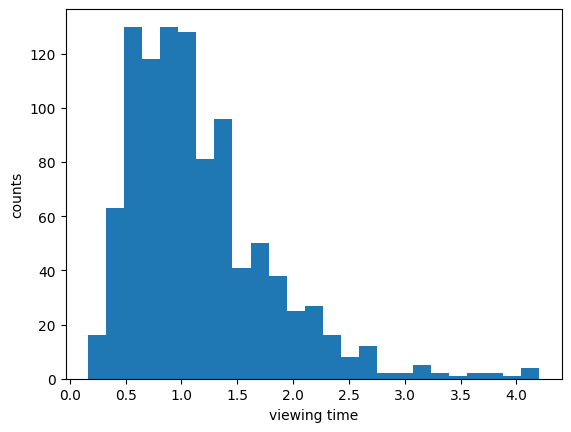

In [13]:
np.random.seed(17)

action_weights = np.random.normal(size=(5,))
m = [
    measure_viewing_time(
        context=np.random.normal(size=(5,)), action_weights=action_weights
    )
    for _ in range(1000)
]
plt.hist(m, 25)
plt.xlabel("viewing time")
plt.ylabel("counts");

In [44]:
class Sample:
    def __init__(self, context, action, reward):
        self.context = context
        self.action = action
        self.reward = reward


def collect_logs_by_action(num_actions, logs):
    samples_y = [[] for _ in range(num_actions)]
    samples_x = [[] for _ in range(num_actions)]

    for sample in logs:
        samples_y[sample.action].append(sample.reward)
        samples_x[sample.action].append(sample.context)

    return samples_y, samples_x

In [45]:
def build_models(num_features, samples_y, samples_x):
    betas = []
    for y, x in zip(samples_y, samples_x):
        y = np.array(y)
        x = np.array(x)
        if len(y) > 0:
            beta = np.linalg.pinv(x.T @ x) @ x.T @ y
        else:
            beta = np.zeros(shape=(num_features,))
        betas.append(beta)
    return betas

In [46]:
class RecommenderGreedy:
    def __init__(self, num_features, num_actions):
        self._num_features = num_features
        self._num_actions = num_actions

    def reset(self):
        self._betas = [
            np.random.normal(size=(num_features,)) for _ in range(self._num_actions)
        ]

    def fit_offline(self, logs):
        samples_y, samples_x = collect_logs_by_action(num_actions, logs)
        self._betas = build_models(self._num_features, samples_y, samples_x)

    def policy(self, context):
        viewing_max = -np.inf
        for action in range(self._num_actions):
            viewing_hat = context @ self._betas[action]
            if viewing_hat > viewing_max:
                action_best = action
                viewing_max = viewing_hat
        return action_best

In [47]:
def log_production_data(action_weights, recommender):
    logs = []
    total_viewing_time = 0
    num_decisions = 100
    for _ in range(num_decisions):
        context = np.random.randint(
            2, size=(len(action_weights),)
        )  # features describing user
        context[0] = 1  # first "feature" is just a constant / intercept term / offset
        action = recommender.policy(context)  # choose best post
        viewing_time = measure_viewing_time(
            context=context, action_weights=action_weights[:, action]
        )
        logs.append(Sample(context, action, viewing_time))
        total_viewing_time += viewing_time
    avg_viewing_time = (total_viewing_time) / num_decisions
    return avg_viewing_time, logs

In [48]:
def run_experiment_sequence(action_weights, num_actions, recommender):
    num_days = 14
    num_features = action_weights.shape[0]
    avg_viewing_times = []
    all_logs = []
    recommender.reset()
    for _ in range(num_days):  # one month
        avg_viewing_time, logs = log_production_data(action_weights, recommender)
        avg_viewing_times.append(avg_viewing_time)
        all_logs.extend(logs)
        recommender.fit_offline(all_logs)  # all data from day one till now

    avg_viewing_times = np.array(avg_viewing_times)
    return avg_viewing_times

In [49]:
def run_sequences(action_weights, num_actions, recommender):
    avg_viewing_times = []
    num_runs = 10
    for _ in range(num_runs):
        avg_viewing_times.append(
            run_experiment_sequence(action_weights, num_actions, recommender)
        )
    avg_viewing_times = np.array(avg_viewing_times)
    mean = avg_viewing_times.mean(axis=0)
    se = avg_viewing_times.std(axis=0) / np.sqrt(num_runs)
    return mean, se

In [50]:
num_features = 5
num_actions = 30

np.random.seed(17)
action_weights = np.random.normal(
    size=(num_features, num_actions)
)  # the dgp; fixed values
recommender = RecommenderGreedy(num_features, num_actions)
mean, se = run_sequences(action_weights, num_actions, recommender)
betas_g = recommender._betas

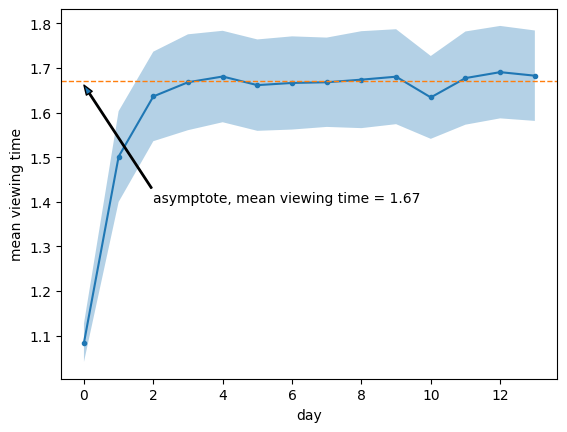

In [55]:
def horizontal_line(y_0):
    c = plt.axis()
    plt.autoscale(False)
    plt.plot([c[0], c[1]], [y_0, y_0], "--", linewidth=1)


arrow_props = {
    "width": 1,
    "headwidth": 5,
    "headlength": 7,
}

plt.plot(mean, ".-")
plt.fill_between(np.arange(len(mean)), mean - se, mean + se, alpha=0.333, linewidth=1)

asymp = mean[4:].mean()
horizontal_line(asymp)

plt.annotate(
    f"asymptote, mean viewing time = {asymp:.2f}",
    xy=[0, asymp - 0.01],
    xytext=[2, 1.4],
    arrowprops=arrow_props,
)

plt.xlabel("day")
plt.ylabel("mean viewing time");

In [54]:
contexts = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
rewards = [0.6, 0.9, 1.3]

x = np.array(contexts)
y = np.array(rewards)
beta_1 = np.linalg.pinv(x.T @ x) @ (x.T @ y)
beta_1

array([0.6, 0.9, 1.3])

In [8]:
contexts = [[1, 0, 0], [0, 1, 0]]
rewards = [0.6, 0.9]

x = np.array(contexts)
y = np.array(rewards)
beta_1 = np.linalg.pinv(x.T @ x) @ (x.T @ y)
beta_1

array([0.6, 0.9, 0. ])

In [60]:
class RecommenderEpsilonGreedy:
    def __init__(self, num_features, num_actions, epsilon=0.1):
        self._num_features = num_features
        self._num_actions = num_actions
        self._epsilon = epsilon

    def reset(self):
        self._betas = [
            np.random.normal(size=(num_features,)) for _ in range(self._num_actions)
        ]

    def fit_offline(self, logs):
        samples_y, samples_x = collect_logs_by_action(num_actions, logs)
        self._betas = build_models(self._num_features, samples_y, samples_x)

    def policy(self, context):
        viewing_max = -np.inf
        if np.random.uniform(0, 1) < self._epsilon:
            action_best = np.random.randint(0, self._num_actions)
        else:
            for action in range(self._num_actions):
                viewing_hat = context @ self._betas[action]
                if viewing_hat > viewing_max:
                    action_best = action
                    viewing_max = viewing_hat
        return action_best

In [61]:
np.random.seed(17)
recommender = RecommenderEpsilonGreedy(num_features, num_actions, epsilon=0.1)
mean_eps, se_eps = run_sequences(action_weights, num_actions, recommender)
betas_eg = recommender._betas

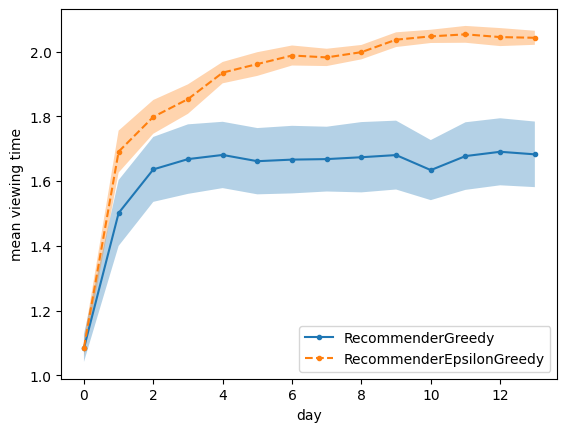

In [64]:
plt.plot(mean, ".-")
plt.plot(mean_eps, ".--")

plt.fill_between(np.arange(len(mean)), mean - se, mean + se, alpha=0.333, linewidth=1)

plt.fill_between(
    np.arange(len(mean_eps)),
    mean_eps - se_eps,
    mean_eps + se_eps,
    alpha=0.333,
    linewidth=1,
)

plt.legend(["RecommenderGreedy", "RecommenderEpsilonGreedy"])
plt.xlabel("day")
plt.ylabel("mean viewing time");

# Thompson Sampling